# Sprint９　深層学習スクラッチ　ニューラルネットワーク

In [1]:
import numpy as np
import random
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # testとtrain分割
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


### データセットの確認

In [3]:
print("X_train{}".format(X_train.shape)) # (60000, 28, 28)
print("X_test{}".format(X_test.shape)) # (10000, 28, 28)
print("y_train{}".format(y_train.shape))# (60000,)
print("y_test{}".format(y_test.shape))#(10000, )
print(X_train[0].dtype) # uint8
#print(X_train[0])

X_train(60000, 28, 28)
X_test(10000, 28, 28)
y_train(60000,)
y_test(10000,)
uint8


### 平滑化

In [4]:
# (1, 28, 28)の各画像を、(1, 784)に変換
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 画像データの可視化

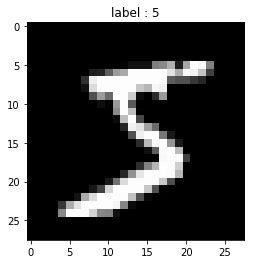

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

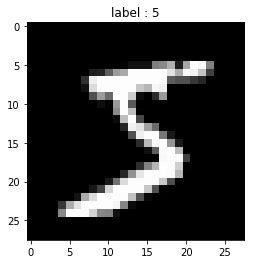

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

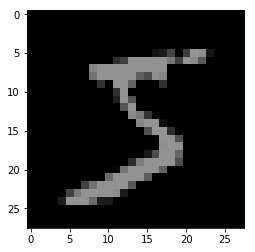

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

## 前処理
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255 # 全て２５５で割っている
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


さらに、訓練用データ6万枚の内2割を検証用データとして分割してください。訓練用データが48000枚、検証用データが12000枚となります。

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000,)
(12000,)


### ミニバッチ処理

これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。

今回はバッチサイズを20とします。今回使う訓練用データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練用データを一度全て見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。

これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


### 学習
ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。

### 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。

重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。

以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います

In [10]:
n_features = 784
n_nodes1 = 400
n_nodes2 = 200 # 2層目のノード数
sigma = 0.01 # ガウス分布の標準偏差
n_output = 10 # 出力のクラス数（3層目のノード数）
W1 = sigma * np.random.randn(n_features, n_nodes1)# (784, 400)
W2 = sigma * np.random.randn(n_nodes1, n_nodes2) # (400, 200)
W3 = sigma * np.random.randn(n_nodes2, n_output) #(200, 10)
# W1: (784, 400)


### 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。

各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

In [11]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

### 【問題3】交差エントロピー誤差の実装

### 【問題4】バックプロパゲーションの実装

### 【問題5】推定

In [12]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, α = 0.001, verbose = True, n_epoc=10,batch_size=100):
        self.verbose = verbose
        #self
        self.batch_size = 20 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数） 
        self.α = α
        self.n_epoc = n_epoc
        self.batch_size = batch_size
    
        #self.fit_Z3 = []
        #損失を記録
        self.loss_list = []
        self.val_loss_list = []

    def _softmax(self, x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T

        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))

    #交差エントロピー関数(仮に作った予測値と正解の差を出す)  
    def _cross_entropy(self, y_train, Z3):
        L = - np.mean(np.sum(y_train*np.log(Z3), axis=1)) #　問７で使う　fit,predictでは使わない
        return L
#         term1 = self.batch_size
#         term2 = np.log(self.Z3)
#         L = -(1/term1)*np.sum(y*term2)
#         return L
    
    def _forward(self, X):
        """ フォワードプロパゲーションのステップを計算　"""

        #１層目
        self.A1 = X@self.W1 + self.B1#(20,400)

        #１層目の活性化関数(tahn関数)
        self.Z1 = np.tanh(self.A1) #(20,400 A1と同じshape)

        #２層目
        self.A2 = self.Z1@self.W2 + self.B2 # (20, 200)

        # 2層目の活性化関数
        self.Z2 = np.tanh(self.A2)#(20, 200)

        # 3層目
        self.A3 = self.Z2@self.W3 + self.B3#(20, 10)

        # 3層目の活性化関数
        self.Z3 = self._softmax(self.A3)#(20,10)１行のsumが１
        
        #print(np.sum(self.Z3, axis=1))
        
        
        return self.Z3,self.A1,self.Z1,self.A2,self.Z2,self.A3
        
    def _Backpropagation(self, X, y,Z3,A1,Z1,A2,Z2,A3):
        """ バックプロパゲーションのステップを計算　"""
    
        # ３層目

        #W３の更新式(tahn関数を使用)
        
        gradientLA3 = self.Z3 - y #(20,10)
        gradientLB3 = np.sum(gradientLA3, axis=0)
        gradientLW3 = self.Z2.T@gradientLA3# (10,)
        gradientLZ2 = gradientLA3@self.W3.T#(20,200)
        
        self.W3 = self.W3 - self.α*gradientLW3#(200,10)
        
        # B3の更新式
        self.B3 = self.B3 - self.α*gradientLB3#(10,)
        
        # 2層目
        
        # W2の更新式
        gradientLA2 = gradientLZ2*(1 - (np.tanh(self.A2)**2))#(20,200)
        gradientLB2 = np.sum(gradientLA2, axis=0)#(200,)
        gradientLW2 = self.Z1.T@gradientLA2#(400,200)
        gradientLZ1 = gradientLA2@self.W2.T#(20,400)
        
        self.W2 =  self.W2 - self.α*gradientLW2#(400,200)
        
        # B2の更新式
        self.B2 = self.B2 - self.α*gradientLB2#(200,)
        
        #１層目
        
        # W1の更新式
        gradientLA1 = gradientLZ1*(1 - (np.tanh(self.A1)**2))
        gradientLB1 = np.sum(gradientLA1, axis=0)#(20,400)
        gradientLW1 = (X.T)@gradientLA1

        
        self.W1 = self.W1 - self.α*gradientLW1#(784,400)
        
        # B1の更新式
        self.B1 = self.B1 - self.α*gradientLB1#(400,)

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # one-hot-encode
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])

        
        # W(重み)の初期値を用意 ＊位置を変えてみた
        sigma = 0.01 # ガウス分布の標準偏差
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)# (784, 400)
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2) # (400, 200)
        self.W3 = sigma * np.random.randn(n_nodes2, n_output) #(200, 10)

        # B(バイアス)の形を用意
        self.B1 = sigma * np.random.randn(self.n_nodes1) #(400, )
        self.B2 = sigma * np.random.randn(self.n_nodes2) #(400, )
        self.B3 = sigma * np.random.randn(self.n_output) #(10, )
        
        #訓練用データが一次元なら二次元に変更
        if y_train.ndim == 1:
            y = y_train[:, np.newaxis]     

        loss = 0
        val_loss = 0
        
        for _ in range(self.n_epoc):
        
            # ミニバッチ２０枚を取得
            get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size)

            for mini_X_train, mini_y_train in get_mini_batch:
                self.Z3,self.A1,self.Z1,self.A2,self.Z2,self.A3 = self._forward(mini_X_train)
                self._Backpropagation(mini_X_train, mini_y_train,self.Z3,self.A1,self.Z1,self.A2,self.Z2,self.A3)
                train_loss = self._cross_entropy(mini_y_train, self.Z3)

            #エポックあたりの損失
            self.loss_list.append(train_loss)
            #print(train_loss)
                
            #検証用データ有り
            if X_val is not None and y_val is not None and y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
            if X_val is not None and y_val is not None: 
                #検証用データのワンホット
                y_val_one_hot = enc.transform(y_val)
                # ミニバッチ２０枚を取得
                get_mini_batch = GetMiniBatch(X_val, y_val_one_hot, batch_size)

                for mini_X_train, mini_y_train in get_mini_batch:
                    self.Z3,self.A1,self.Z1,self.A2,self.Z2,self.A3 = self._forward(mini_X_train)
                    self._Backpropagation(mini_X_train, mini_y_train,self.Z3,self.A1,self.Z1,self.A2,self.Z2,self.A3)
                    val_loss = self._cross_entropy(mini_y_train, self.Z3)

                #エポックあたりの損失                
                self.val_loss_list.append(val_loss)
                #print(val_loss)
                #plt.plot(self.loss_list, self.val_loss_list)       

    def predict(self, X_val):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pred,_,_,_,_,_ = self._forward(X_val)        
        predict = np.argmax(pred, axis=1)
        
#         #エポックあたりの損失
#         val_loss = self._cross_entropy(X_val, pred)
#         self.loss_list.append(val_loss)
        #print(val_loss)
        #plt.plot(self.loss_list)
        
        #学習曲線をプロット
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(self.loss_list, label='train loss')
        ax.plot(self.val_loss_list, label='val loss')

        ax.legend()
        ax.set_xlabel("epoc [num]")
        ax.set_ylabel("cross entorpy")
        #ax.set_ylim(0, 3)

        plt.show()

        return predict

### 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

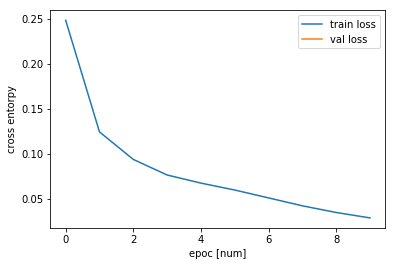

正解率 ：0.9559166666666666
予測
[7 9 9 9 6 9 6 1 7 4 8 1 3 6 8 3 3 7 6 0 6 5 0 0 9 2 9 6 9 1 4 1 2 1 5 5 5
 2 6 4 9 1 6 8 2 7 7 8 4 4 5 5 6 4 6 1 3 1 2 9 9 3 3 4 8 1 2 4 8 6 0 6 2 8
 3 3 0 4 3 4 1 0 8 9 1 6 9 6 4 2 0 5 2 4 0 7 4 7 9 1 4 3 1 3 0 9 0 9 5 4 3
 2 5 4 7 5 4 7 8 4 7 2 1 2 9 8 0 8 1 6 7 9 0 6 7 4 5 9 4 5 5 1 7 9 9 0 5 9
 2 3 7 0 6 1 1 3 4 5 6 6 8 0 6 1 2 6 1 1 4 3 3 5 9 6 6 7 9 9 7 8 7 4 6 3 8
 9 6 9 1 5 0 4 2 7 4 5 7 6 8 3 0 8 2 3 8 3 3 2 7 0 2 1 8 3 1 1 4 9 6 4 7 4
 2 5 4 1 1 8 9 0 7 1 7 8 7 4 5 3 4 6 9 3 8 5 1 8 8 2 6 0 7 5 3 9 4 6 6 5 8
 9 5 8 2 1 1 6 1 5 3 1 9 5 0 4 4 8 5 4 3 0 4 1 9 9 0 6 3 7 9 1 4 2 4 5 4 6
 9 2 8 2]
正解：
[7 9 9 9 6 9 6 1 7 4 8 1 3 6 2 3 3 7 6 0 6 5 0 0 9 2 9 6 9 1 4 1 2 1 5 5 5
 2 6 4 9 1 6 8 2 7 7 8 4 4 5 5 6 9 6 1 3 1 2 9 9 3 3 4 8 1 2 4 8 9 0 6 2 8
 3 3 0 4 3 4 1 0 8 3 1 2 9 6 4 2 0 5 2 4 0 7 4 3 9 1 4 3 1 3 0 9 0 9 0 4 3
 1 5 4 7 5 4 7 8 4 7 2 1 2 9 8 0 8 1 6 7 9 0 2 7 4 5 9 4 5 5 1 7 9 3 0 5 9
 2 3 7 0 6 1 1 3 4 5 6 5 8 0 6 1 2 6 1 1 4 3 3 5 9 6 6 7 9 

In [13]:
NNC = ScratchSimpleNeuralNetrowkClassifier()
NNC.fit(X_train, y_train)
pred = NNC.predict(X_val)
print("正解率 ：{}".format(accuracy_score(y_val, pred)))
print("予測\n{}".format(pred[:300]))
print("正解：\n{}".format(y_val[:300]))

### 【問題7】学習曲線のプロット

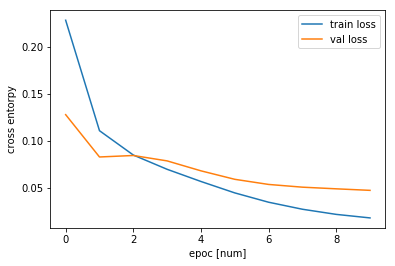

正解率 ：0.9770833333333333
予測
[7 9 9 9 6 9 6 1 7 4 8 1 3 6 2 3 3 7 6 0 6 5 0 0 9 2 9 6 9 1 4 1 2 1 5 5 5
 2 6 4 9 1 6 8 2 7 7 8 4 4 5 5 6 9 6 1 3 1 2 9 9 3 3 4 8 1 2 4 8 8 0 6 2 8
 3 3 0 4 3 4 1 0 8 3 1 2 9 6 4 2 0 5 2 4 0 7 4 7 9 1 4 3 1 3 0 9 0 9 0 4 3
 2 5 4 7 5 4 7 8 4 7 2 1 2 9 8 0 8 1 6 7 9 0 2 7 4 5 9 4 5 5 1 7 9 3 0 5 9
 2 3 7 0 6 1 1 3 4 5 6 5 8 0 6 1 2 6 1 1 4 3 3 5 9 6 6 7 9 9 7 8 7 4 6 3 8
 9 6 9 1 5 0 4 2 7 4 5 7 6 8 3 0 8 2 3 8 3 3 2 7 0 2 1 8 3 1 1 4 9 6 4 7 4
 2 5 4 1 1 8 9 0 7 1 7 8 7 4 5 3 4 6 9 3 8 5 1 8 8 2 6 0 7 5 3 0 8 6 6 5 8
 9 5 8 2 1 1 6 1 5 3 1 9 5 0 4 4 8 5 4 3 0 4 1 9 9 0 6 3 3 1 1 4 2 4 5 4 6
 9 2 8 2]
正解：
[7 9 9 9 6 9 6 1 7 4 8 1 3 6 2 3 3 7 6 0 6 5 0 0 9 2 9 6 9 1 4 1 2 1 5 5 5
 2 6 4 9 1 6 8 2 7 7 8 4 4 5 5 6 9 6 1 3 1 2 9 9 3 3 4 8 1 2 4 8 9 0 6 2 8
 3 3 0 4 3 4 1 0 8 3 1 2 9 6 4 2 0 5 2 4 0 7 4 3 9 1 4 3 1 3 0 9 0 9 0 4 3
 1 5 4 7 5 4 7 8 4 7 2 1 2 9 8 0 8 1 6 7 9 0 2 7 4 5 9 4 5 5 1 7 9 3 0 5 9
 2 3 7 0 6 1 1 3 4 5 6 5 8 0 6 1 2 6 1 1 4 3 3 5 9 6 6 7 9 

In [14]:
NNC = ScratchSimpleNeuralNetrowkClassifier(α = 0.001, verbose = True, n_epoc=10,batch_size=100)
NNC.fit(X_train, y_train, X_val, y_val)
pred = NNC.predict(X_val)
print("正解率 ：{}".format(accuracy_score(y_val, pred)))
print("予測\n{}".format(pred[:300]))
print("正解：\n{}".format(y_val[:300]))

### 【問題8】（アドバンス課題）誤分類の確認

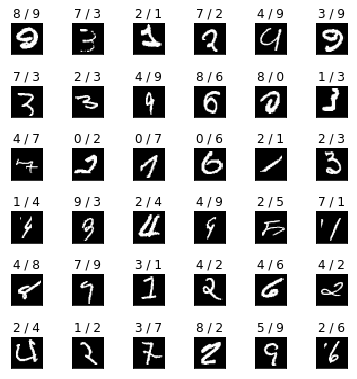

In [19]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt

y_pred = pred

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')